In [25]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn import model_selection
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics

import nltk
from nltk.stem.snowball import SnowballStemmer
import ssl

import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import itertools

In [58]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_ru')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/yarvod/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /Users/yarvod/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_ru is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yarvod/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Base Data Preporation

In [3]:
with open('data/data.json') as f:
    data_raw = json.load(f)
    messages = [m['message'] for m in data_raw]
dfMessages = pd.DataFrame({'message': messages})
dfMessages = dfMessages.dropna()
dfMessages = dfMessages[~dfMessages.message.str.contains('#резюме')]
dfMessages

,message
0,
1,#вакансия\n\nTest Lead/Test Engineer/\nTechnic...
2,"#вакансия\n\nМладший аналитик\n\nМосква, м. Во..."
3,#вакансия\n\nMiddle React Native Front-Ender\n...
4,#вакансия\n\nНазвание компании: Сбер\n\nДолжно...
...,...
861,У меня есть Мега-парсер инсты. Разыскивается ф...
862,#job #вакансия\n\nАналитик или разработчик (ав...
863,#вакансия \nЛьвов —> Лос-Анджелес\nОфис (иногд...
864,#job #вакансия\nДолжность: Senior Android deve...


In [97]:
# На эти категории будет классифицировать предложения, в файле data/clear_labeled.csv я раскидал на нескольких лэйблы
class MessageBlocks:
    OTHER = 0  # то, что не распознать
    CONTACTS = 1  # контакт
    VACANCY_NAME = 2  # название вакансии
    COMPANY_NAME = 3  # название компании
    VACANCY_DESCRIPTION = 4  # описание вакансии
    COMPANY_DESCRIPTION = 5  # описание компании
    FORMAT = 6  # формат работы
    POSITION = 7  # позиция
    LEVEL = 8  # уровень позиции
    DUTIES = 9  # обязанности
    ADDRESS_OFFICE = 10  # адрес офиса
    REQUIREMENTS = 11  # требования
    SALARY = 12  # зарплата
    EMPLOYMENT = 13  # занятость
    SITE = 14  # сайт компании
    ADDITIONAL_INFO = 15  # доп информация
    STACK_TECH = 16  # стэк технологий
    WORK_CONDITIONS = 17  # условия работы

    MAP = dict((
        (OTHER, 'Other'),
        (CONTACTS, 'Contacts'),
        (VACANCY_NAME, 'Vacancy Name'),
        (COMPANY_NAME, 'Company Name'),
        (VACANCY_DESCRIPTION, 'Vacancy Description'),
        (COMPANY_DESCRIPTION, 'Company Description'),
        (FORMAT, 'Format'),
        (POSITION, 'Position'),
        (LEVEL, 'Level'),
        (DUTIES, 'Duties'),
        (ADDRESS_OFFICE, 'Address Office'),
        (REQUIREMENTS, 'Requirements'),
        (SALARY, 'Salary'),
        (EMPLOYMENT, 'Employment'),
        (SITE, 'Site'),
        (ADDITIONAL_INFO, 'Additional Info'),
        (STACK_TECH, 'Stack Tech'),
        (WORK_CONDITIONS, 'Work Conditions'),
    ))
    

In [29]:
all_sentances = {'label': [], 'sentence': []}


def condition(s: str):
    if s == '':
        return False
    if '#' in s:
        return False
    return True

for row in dfMessages['message'].iloc[1:]:
    if row:
        sentances = [nltk.tokenize.sent_tokenize(s) for s in row.split('\n') if condition(s)]
        sentances = list(itertools.chain.from_iterable(sentances))
        labels = [0 for s in sentances]
        all_sentances['sentence'] += sentances
        all_sentances['label'] += labels

dfPrepared = pd.DataFrame(all_sentances)
dfPrepared.to_csv('data/clear.csv', index=False)
dfPrepared

,label,sentence
0,0,Test Lead/Test Engineer/
1,0,Technical Integration Consultant/
2,0,Functional Consultant/
3,0,Configuration Environment Management Consultant
4,0,"Город и адрес офиса: Кипр, Никосия"
...,...,...
21353,0,"Kristof Cools, assistant professor"
21354,0,Application form and more detailed description...
21355,0,https://www.academictransfer.com/en/290845/phd...
21356,0,Application deadline:


In [61]:
dfLabeled = pd.read_csv('data/clear_labeled.csv').iloc[:223]
dfLabeled.head(10)

,label,sentence
0,7,Test Lead/Test Engineer/
1,7,Technical Integration Consultant/
2,7,Functional Consultant/
3,7,Configuration Environment Management Consultant
4,10,"Город и адрес офиса: Кипр, Никосия"
5,6,"Формат работы: гибрид, 2/3 дня в неделю в офисе"
6,13,Занятость: полная
7,12,"Зарплатная вилка: от 2000 до 5000€, возможно и..."
8,4,Описание вакансии: подробные описания в брошюр...
9,3,Название компании: Murex


In [62]:
dfLabeled.tail(10)

,label,sentence
213,16,"SQL (без него никуда), Python (желательно, но ..."
214,1,Контакты: пишите лично мне @oganesian.
215,7,Должность стажер в Сбер
216,10,"Город Москва, Кутузовская"
217,12,Вилка 57 700 gross за 40 часов.
218,6,Можно part-time
219,13,Режим работы: смешанный - желательно иногда в ...
220,0,Описание вакансии Всем привет!
221,2,Ищу себе в команду (сервис “Новостной монитори...
222,15,"По правилам стажировки можно взять только тех,..."


In [63]:
desc = dfLabeled.groupby('label').describe()
desc

sentence                                                               
         count unique                                                top freq
label                                                                        
0           15     13                                            Привет!    2
1            8      8                                 Контакты: @jeipiem    1
2            2      2  Ищем амбициозных Middle PHP + Laravel разработ...    1
3            9      9                           Название компании: Murex    1
4           14     14  Описание вакансии: подробные описания в брошюр...    1
5            8      8    Меня зовут Тим, CTO&CPO и основатель CentiMeta.    1
6            9      9    Формат работы: гибрид, 2/3 дня в неделю в офисе    1
7           13     13                           Test Lead/Test Engineer/    1
9           33     32                                       Обязанности:    2
10          10      9  Локация: Москва, гибрид, удаленка +- 4 часа от...    2
11          43     41                                        Требования:    2
12          12     12  Зарплатная вилка: от 2000 до 5000€, возможно и...    1
13           8      6                                  Занятость: полная    2
14           2      2                       Сайт продукта: centimeta.org    1
15          11     11  Кстати, абсолютно норм, если ты студент старши...    1
16           7      7       Основные используемые технологии на проекте:    1
17          19     19                       Какие условия мы предлагаем:    1

## Preporation

In [64]:
text = np.array(dfLabeled.sentence.values)
target = dfLabeled.label.astype(int).values

In [65]:
def upperCaseRate(string):
    "Returns percentage of uppercase letters in the string"
    return np.array(list(map(str.isupper, string))).mean()

In [66]:
upcaseRate = list(map(upperCaseRate, dfLabeled.sentence.values))

In [67]:
def cleanText(string):
    """This function deletes all symbols except Cyrilic and Base Latin alphabet,
    stopwords, functional parts of speech. Returns string of words stem."""
    # Common cleaning
    string = string.lower()
    string = re.sub(r"http\S+", "", string)
    string = str.replace(string,'Ё','е')
    string = str.replace(string,'ё','е')
    prog = re.compile('[А-Яа-яA-Za-z]+')
    words = prog.findall(string.lower())
    
    # Word Cleaning
    ## Stop Words
    stopwords = nltk.corpus.stopwords.words('russian')
    words = [w for w in words if w not in stopwords]
    ## Cleaning functional POS (Parts of Speech)
    functionalPos = {'CONJ', 'PRCL'}
    words = [w for w, pos in nltk.pos_tag(words, lang='rus') if pos not in functionalPos]
    ## Stemming
    stemmer = SnowballStemmer('russian')
    return ' '.join(list(map(stemmer.stem, words)))

In [80]:
%%time
text = list(map(cleanText, text))

CPU times: user 254 ms, sys: 15.9 ms, total: 270 ms
Wall time: 269 ms


## Proccessing

In [69]:
X_train, X_test, y_train, y_test = train_test_split(text, target, test_size=.3, stratify=target, shuffle = True, random_state=0)
print('Dim of train:', len(X_train), '\tTarget rate: {:.2f}%'.format(y_train.mean()))
print("Dim of test:", len(X_test), '\tTarget rate: {:.2f}%'.format(y_test.mean()))

Dim of train: 156 	Target rate: 9.04%
Dim of test: 67 	Target rate: 9.18%


## Baseline

In [70]:
clf_pipeline = Pipeline(
            [("vectorizer", TfidfVectorizer()), # Prod feature: tokenizer=cleanText
            ("classifier", LinearSVC())]
        )

clf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('classifier', LinearSVC())])

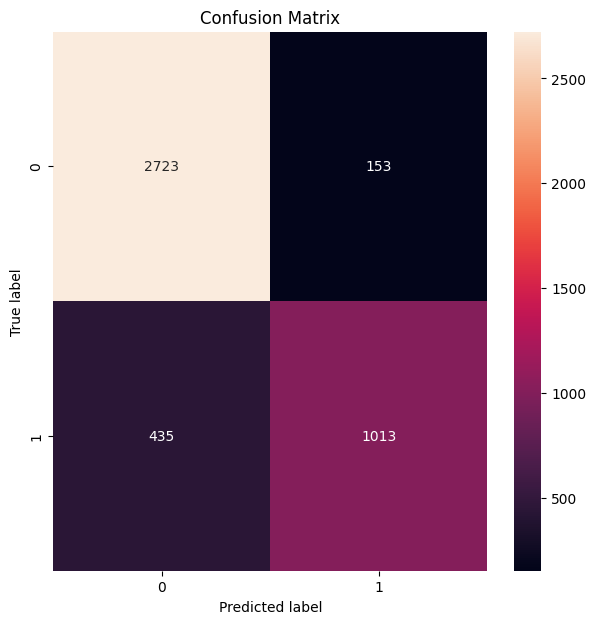

In [27]:
cm = metrics.confusion_matrix(y_test, clf_pipeline.predict(X_test))

def plotConfusionMatrix(cm):
    fig = plt.figure(figsize=(7,7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return None

plotConfusionMatrix(cm)

In [72]:
print(metrics.classification_report(y_test, clf_pipeline.predict(X_test)))
f1_base = metrics.f1_score(y_test, clf_pipeline.predict(X_test), average='weighted')

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         4
           1       1.00      0.50      0.67         2
           2       0.00      0.00      0.00         1
           3       0.60      1.00      0.75         3
           4       0.40      0.50      0.44         4
           5       0.00      0.00      0.00         2
           6       1.00      0.67      0.80         3
           7       0.60      0.75      0.67         4
           9       0.73      0.80      0.76        10
          10       0.67      0.67      0.67         3
          11       0.75      0.92      0.83        13
          12       1.00      1.00      1.00         4
          13       0.67      1.00      0.80         2
          14       1.00      1.00      1.00         1
          15       0.00      0.00      0.00         3
          16       0.00      0.00      0.00         2
          17       0.75      0.50      0.60         6

    accuracy              

/Users/yarvod/workspace/phystech.job-projects/pj-nlp/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yarvod/workspace/phystech.job-projects/pj-nlp/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yarvod/workspace/phystech.job-projects/pj-nlp/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

## Work Test

In [87]:
dfTest = pd.read_csv('data/clear_labeled.csv').iloc[223:500]
dfTest

,label,sentence
223,0,Мы занимаемся разработкой NLP моделей для анал...
224,0,Сейчас ищем аналитика с уклоном в DS.
225,0,"Задачи, которые можем предложить на стажировку:"
226,0,• Суммаризация новостей (генерим саммари и смо...
227,0,• Тематическое моделирование (мировые тренды)
...,...,...
495,0,• Удаленная работа
496,0,Требования:
497,0,"Python, C++, SQL"
498,0,Чем предстоит заниматься:


In [89]:
testText = np.array(dfTest.sentence.values)

In [94]:
%%time
cleantext = list(map(cleanText, testText))

CPU times: user 263 ms, sys: 15.7 ms, total: 279 ms
Wall time: 278 ms


In [96]:
pr_labels = clf_pipeline.predict(cleantext)

In [99]:
blocks = [MessageBlocks.MAP[pr_label] for pr_label in pr_labels]
dfPredicted = pd.DataFrame({'label': pr_labels, 'block': blocks, 'sentence': testText})
dfPredicted.to_csv('data/predicted.csv', index=False)
dfPredicted

,label,block,sentence
0,9,Duties,Мы занимаемся разработкой NLP моделей для анал...
1,7,Position,Сейчас ищем аналитика с уклоном в DS.
2,9,Duties,"Задачи, которые можем предложить на стажировку:"
3,11,Requirements,• Суммаризация новостей (генерим саммари и смо...
4,11,Requirements,• Тематическое моделирование (мировые тренды)
...,...,...,...
272,17,Work Conditions,• Удаленная работа
273,11,Requirements,Требования:
274,11,Requirements,"Python, C++, SQL"
275,5,Company Description,Чем предстоит заниматься:
